In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

KeyboardInterrupt: 

In [ ]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')

In [ ]:
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')
YC.reshape(2160,2160)[-200,0]

In [ ]:
fs = 2*2*np.pi/24/3600*np.sin(-57*np.pi/180)
fn = 2*2*np.pi/24/3600*np.sin(-26.7*np.pi/180)

In [ ]:
fs

In [ ]:
fn

In [ ]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [ ]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [ ]:

zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm)

In [ ]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_vels.zarr')
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_eta_nom.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
eta_eul = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta.zarr')

uvel_filtered = vels_filtered.u.isel(time=slice(2,110))
vvel_filtered = vels_filtered.v.isel(time=slice(2,110))
ssh_filtered = eta_filtered.eta.isel(time=slice(2,110))

uvel_unfiltered = vels_unfiltered.u.isel(time=slice(2,110))
vvel_unfiltered = vels_unfiltered.v.isel(time=slice(2,110))
ssh_unfiltered = eta_unfiltered.eta.isel(time=slice(2,110))


#uvel_filtered = uvel_filtered.drop_vars('time')
#vvel_filtered = vvel_filtered.drop_vars('time')
#uvel_unfiltered = uvel_unfiltered.drop_vars('time')
#vvel_unfiltered = vvel_unfiltered.drop_vars('time')
grid = Grid(uvel_filtered, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [ ]:
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)[:,0]*np.pi/180)

In [ ]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600,0)), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=uvel_unfiltered.time.shape[0]
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
eta_eul_filtered = eta_eul.Eta.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_filtered = eta_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [ ]:
weight.isel(j=-1).plot()

In [ ]:
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')

uvel_unf_mr = uvel_unfiltered-uvel_unfiltered.mean('time')
vvel_unf_mr = vvel_unfiltered-vvel_unfiltered.mean('time')
uvel_f_mr = uvel_filtered-uvel_unfiltered.mean('time')
vvel_f_mr = vvel_filtered-vvel_unfiltered.mean('time')
uvel_ef_mr = u_eul_filtered-uvel_unfiltered.mean('time')
vvel_ef_mr = v_eul_filtered-vvel_unfiltered.mean('time')
eta_ef_mr = (eta_eul_filtered-eta_mean.Eta).where(np.isfinite(ssh_filtered.isel(time=0)))

In [ ]:
#spectrum unfiltered lagrang
with ProgressBar():
    uhat_un = xrft.power_spectrum(uvel_unf_mr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    vhat_un = xrft.power_spectrum(vvel_unf_mr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    eta_un = xrft.power_spectrum(ssh_unfiltered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()
ekehat_un = .5*(uhat_un + vhat_un)

In [ ]:
#spectrum_filtered_lagrang
with ProgressBar():
    uhat2 = xrft.power_spectrum(uvel_f_mr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    vhat2 = xrft.power_spectrum(vvel_f_mr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    eta2 = xrft.power_spectrum(ssh_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()
ekehat = .5*(uhat2 + vhat2)

In [ ]:
#spectrum_filtered_eul
with ProgressBar():
    uhat2eul = xrft.power_spectrum(uvel_ef_mr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    vhat2eul = xrft.power_spectrum(vvel_ef_mr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()#, detrend='linear'
    eta2eul = xrft.power_spectrum(eta_ef_mr.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()
ekehat_eul = .5*(uhat2eul + vhat2eul)

In [ ]:
spec0 = int((ekehat['freq_time'].size-1)/2)

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(321)
spec0 = int((ekehat['freq_time'].size-1)/2)
(ekehat_un*ekehat_un.freq_time).assign_coords(freq_time=ekehat_un.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Unfiltered \n spectrum')
(ekehat_eul*ekehat_eul.freq_time).assign_coords(freq_time=ekehat_eul.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Eulerian filtered \n spectrum')
(ekehat*ekehat.freq_time).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Lagrangian filtered \n spectrum')


plt.xscale('log')
plt.yscale('log')
plt.axvline([2/86400*3600],label='Semi-diurnal freq.',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial freq.',color='k')
#plt.axvline([-fs/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-fn/2/np.pi*3600],label='Inertial frequency',color='k')

plt.ylim(10**-11,1)
plt.xlim(0.025,0.5)

xticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]
plt.xticks(xticks_s,xticks_s,rotation=45)

plt.ylabel('Mean power spectral density')
plt.xlabel('')
plt.title('Horizontal velocity, whole domain')

plt.subplot(322)
(eta_un*eta_un.freq_time).assign_coords(freq_time=eta_un.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Unfiltered \n spectrum')
(eta2eul*eta2eul.freq_time).assign_coords(freq_time=eta2eul.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Eulerian filtered \n spectrum')
(eta2*eta2.freq_time).assign_coords(freq_time=eta2.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Lagrangian filtered \n spectrum')

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.025,0.5)
plt.ylim(10**-11,1)
plt.axvline([2/86400*3600],label='Semi-diurnal freq.',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial freq.',color='k')
plt.title('Sea surface height, whole domain')
#plt.legend(fontsize=12)

plt.xlabel('')
xticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]
plt.xticks(xticks_s,xticks_s,rotation=45)


plt.subplot(323)
spec0 = int((ekehat['freq_time'].size-1)/2)
(ekehat_un*ekehat_un.freq_time).isel(j=slice(0,440)).assign_coords(freq_time=ekehat_un.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Unfiltered \n spectrum')
(ekehat_eul*ekehat_eul.freq_time).isel(j=slice(0,440)).assign_coords(freq_time=ekehat_eul.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Eulerian filtered \n spectrum')
(ekehat*ekehat.freq_time).isel(j=slice(0,440)).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Lagrangian filtered \n spectrum')


plt.xscale('log')
plt.yscale('log')
plt.axvline([2/86400*3600],label='Semi-diurnal freq.',color='b')
#plt.axvline([-fm/2/np.pi*3600],label='Inertial freq.',color='k')
plt.axvline([-fs/2/np.pi*3600],label='Inertial frequency',color='k')
#plt.axvline([-fn/2/np.pi*3600],label='Inertial frequency',color='k')

plt.ylim(10**-11,1)
plt.xlim(0.025,0.5)

xticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]
plt.xticks(xticks_s,xticks_s,rotation=45)

plt.ylabel('Mean power spectral density')
plt.xlabel('')
plt.title('Horizontal velocity 57S--52S')


plt.subplot(324)
(eta_un*eta_un.freq_time).isel(j=slice(0,440)).assign_coords(freq_time=eta_un.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Unfiltered \n spectrum')
(eta2eul*eta2eul.freq_time).isel(j=slice(0,440)).assign_coords(freq_time=eta2eul.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Eulerian filtered \n spectrum')
(eta2*eta2.freq_time).isel(j=slice(0,440)).assign_coords(freq_time=eta2.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Lagrangian filtered \n spectrum')

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.025,0.5)
plt.ylim(10**-11,1)
plt.axvline([2/86400*3600],label='Semi-diurnal freq.',color='b')
plt.axvline([-fs/2/np.pi*3600],label='Inertial freq.',color='k')
plt.title('Sea surface height 57S--52S')
plt.legend(fontsize=12,loc='upper right')

plt.xlabel('')
xticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]
plt.xticks(xticks_s,xticks_s,rotation=45)


plt.subplot(325)
spec0 = int((ekehat['freq_time'].size-1)/2)
(ekehat_un*ekehat_un.freq_time).isel(j=slice(1860,2200)).assign_coords(freq_time=ekehat_un.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Unfiltered \n spectrum')
(ekehat_eul*ekehat_eul.freq_time).isel(j=slice(1860,2200)).assign_coords(freq_time=ekehat_eul.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Eulerian filtered \n spectrum')
(ekehat*ekehat.freq_time).isel(j=slice(1860,2200)).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Lagrangian filtered \n spectrum')


plt.xscale('log')
plt.yscale('log')
plt.axvline([2/86400*3600],label='Semi-diurnal freq.',color='b')
#plt.axvline([-fm/2/np.pi*3600],label='Inertial freq.',color='k')
#plt.axvline([-fs/2/np.pi*3600],label='Inertial frequency',color='k')
plt.axvline([-fn/2/np.pi*3600],label='Inertial frequency',color='k')

plt.ylim(10**-11,1)
plt.xlim(0.025,0.5)

xticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]
plt.xticks(xticks_s,xticks_s,rotation=45)

plt.ylabel('Mean power spectral density')
plt.xlabel('Frequency (cph)')
plt.title('Horizontal velocity 31S--26S')


plt.subplot(326)
(eta_un*eta_un.freq_time).isel(j=slice(1860,2200)).assign_coords(freq_time=eta_un.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Unfiltered \n spectrum')
(eta2eul*eta2eul.freq_time).isel(j=slice(1860,2200)).assign_coords(freq_time=eta2eul.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Eulerian filtered \n spectrum')
(eta2*eta2.freq_time).isel(j=slice(1860,2200)).assign_coords(freq_time=eta2.freq_time*3600).mean(['i','j'])[spec0:].plot(label='Lagrangian filtered \n spectrum')

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.025,0.5)
plt.ylim(10**-11,1)
plt.axvline([2/86400*3600],label='Semi-diurnal freq.',color='b')
plt.axvline([-fn/2/np.pi*3600],label='Inertial freq.',color='k')
plt.title('Sea surface height 31S--26S')
#plt.legend(fontsize=12)

plt.xlabel('Frequency (cph)')
xticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]
plt.xticks(xticks_s,xticks_s,rotation=45)

plt.tight_layout()

fig = plt.gcf()
fig.savefig("spectrum.png")

In [32]:
1.361111e-04/2*3600

0.24499997999999998

In [170]:
YG.reshape(2160,2160)[2159,0]

-26.66853

In [48]:
17*3

51

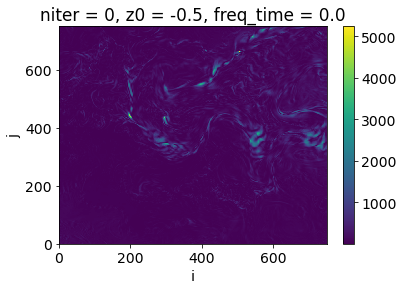

In [56]:
ekehat.isel(i=slice(1300,2050)).isel(j=slice(900,1650)).isel(freq_time=spec0).plot(x='i')

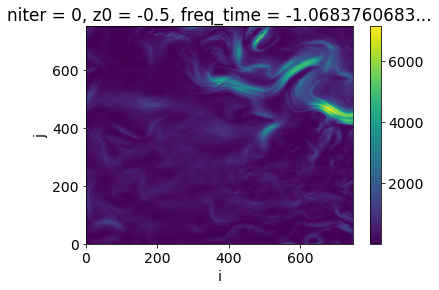

In [100]:
ekehat.isel(i=slice(100,850)).isel(j=slice(100,850)).isel(freq_time=spec0).plot(x='i')

(0.04, 2.8)

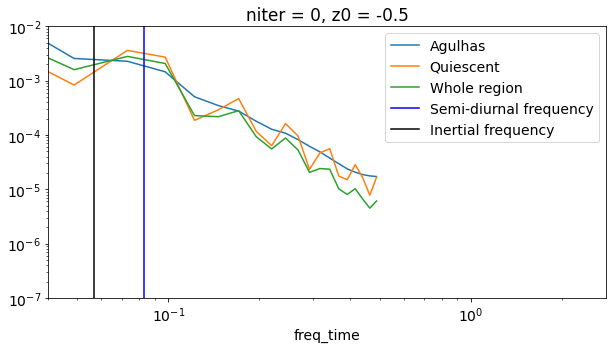

In [24]:
plt.figure(figsize=(10,5))
spec0 = int((ekehat['freq_time'].size-1)/2)
(ekehat_un*ekehat_un.freq_time).isel(i=slice(1300,2050)).isel(j=slice(900,1650)
                                            ).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j']
                                                                                                 )[spec0:].plot(label='Agulhas')
(ekehat_un*ekehat_un.freq_time).isel(i=slice(100,850)).isel(j=slice(100,850)).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j']
                                                                                                 )[spec0:].plot(label='Quiescent')
(ekehat_un*ekehat_un.freq_time).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j']
                                                                                                 )[spec0:].plot(label='Whole region')

plt.xscale('log')
plt.yscale('log')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
plt.legend()
plt.ylim(10**-7,10**-2)
plt.xlim(0.04,2.8)

(0.04, 2.8)

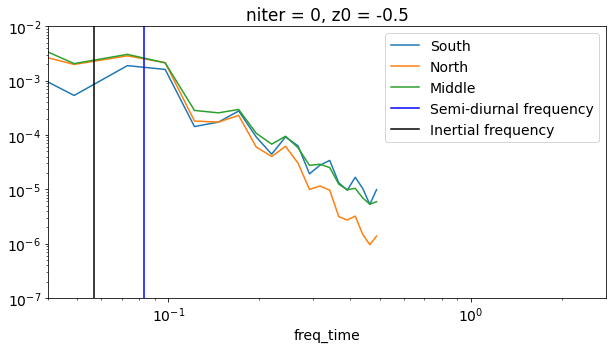

In [25]:
plt.figure(figsize=(10,5))
spec0 = int((ekehat['freq_time'].size-1)/2)
(ekehat_un*ekehat_un.freq_time).isel(j=slice(0,500)
                                            ).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j']
                                                                                                 )[spec0:].plot(label='South')
(ekehat_un*ekehat_un.freq_time).isel(j=slice(-500,-1)).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j']
                                                                                                 )[spec0:].plot(label='North')
(ekehat_un*ekehat_un.freq_time).isel(j=slice(750+80,1250+80)).assign_coords(freq_time=ekehat.freq_time*3600).mean(['i','j']
                                                                                                 )[spec0:].plot(label='Middle')

plt.xscale('log')
plt.yscale('log')
plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
plt.legend()
plt.ylim(10**-7,10**-2)
plt.xlim(0.04,2.8)